# Building a Libor Curve

This is an example of a replication of a BBG example from

https://github.com/vilen22/curve-building/blob/master/Bloomberg%20Curve%20Building%20Replication.xlsx

Agreement is very good however some issues about date generation need to be checked.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.products.rates import *

####################################################################
# FINANCEPY BETA Version 0.191 - This build:  17 Jan 2021 at 21:17 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#      Send any bug reports or comments to quant@financepy.com     #
####################################################################



## Creating the Libor Instruments

In [3]:
valuation_date = Date(6, 6, 2018)

### Load up the deposits first

In [4]:
spot_days = 0
settlement_date = valuation_date.add_weekdays(spot_days)

In [5]:
depoDCCType = DayCountTypes.THIRTY_E_360_ISDA
depos = []
deposit_rate = 0.0231381
maturity_date = settlement_date.add_months(3)
depo = IborDeposit(settlement_date, maturity_date, deposit_rate, depoDCCType)
depos.append(depo)

### Create Strips of Interest Rate Futures 

In [6]:
futs = []
fut = IborFuture(valuation_date, 1) ; futs.append(fut)
fut = IborFuture(valuation_date, 2) ; futs.append(fut)
fut = IborFuture(valuation_date, 3) ; futs.append(fut)
fut = IborFuture(valuation_date, 4) ; futs.append(fut)
fut = IborFuture(valuation_date, 5) ; futs.append(fut)
fut = IborFuture(valuation_date, 6) ; futs.append(fut)

### Convert Interest Rate Futures to FRAs

Need to supply futures price and the convexity (in percent)

In [7]:
fras = [None]*6
fras[0] = futs[0].to_fra(97.6675,-0.00005)
fras[1] = futs[1].to_fra(97.5200,-0.00060)
fras[2] = futs[2].to_fra(97.3550,-0.00146)
fras[3] = futs[3].to_fra(97.2450,-0.00263)
fras[4] = futs[4].to_fra(97.1450,-0.00411)
fras[5] = futs[5].to_fra(97.0750,-0.00589)

### Then we load up swap rates

In [8]:
accrual = DayCountTypes.THIRTY_E_360
freq = FrequencyTypes.SEMI_ANNUAL
longEnd = DateGenRuleTypes.BACKWARD
swapType = SwapTypes.PAY

In [9]:
spot_days = 2
settlement_date = valuation_date.add_weekdays(spot_days)
notional = ONE_MILLION

In [10]:
swaps = []
swap = IborSwap(settlement_date, "2Y", swapType, (2.77417+2.77844)/200, freq, accrual, notional); swaps.append(swap)
swap = IborSwap(settlement_date, "3Y", swapType, (2.86098+2.86582)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settlement_date, "4Y", swapType, (2.90240+2.90620)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settlement_date, "5Y", swapType, (2.92944+2.92906)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settlement_date, "6Y", swapType, (2.94001+2.94499)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settlement_date, "7Y", swapType, (2.95352+2.95998)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settlement_date, "8Y", swapType, (2.96830+2.97400)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settlement_date, "9Y", swapType, (2.98403+2.98817)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settlement_date, "10Y", swapType, (2.99716+3.00394)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settlement_date, "11Y", swapType, (3.01344+3.01596)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settlement_date, "12Y", swapType, (3.02276+3.02684)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settlement_date, "15Y", swapType, (3.04092+3.04508)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settlement_date, "20Y", swapType, (3.04417+3.05183)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settlement_date, "25Y", swapType, (3.03219+3.03621)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settlement_date, "30Y", swapType, (3.01030+3.01370)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settlement_date, "40Y", swapType, (2.96946+2.97354)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settlement_date, "50Y", swapType, (2.91552+2.93748)/200, freq, accrual); swaps.append(swap)

## Build the Curve

In [11]:
depos

[OBJECT TYPE: IborDeposit
 START DATE: 06-JUN-2018
 MATURITY DATE: 06-SEP-2018
 NOTIONAL: 100.0
 DEPOSIT RATE: 0.0231381
 DAY COUNT TYPE: DayCountTypes.THIRTY_E_360_ISDA
 CALENDAR: CalendarTypes.WEEKEND
 BUS DAY ADJUST TYPE: BusDayAdjustTypes.MODIFIED_FOLLOWING]

In [12]:
settlement_date

08-JUN-2018

In [13]:
libor_curve = IborSingleCurve(valuation_date, depos, fras, swaps)

## Curve Examination

Generate a vector of time points and then generate zero rates and forward rates

In [14]:
years = np.linspace(0.01,50,1000)
dates = settlement_date.add_years(years)
zero_rates = libor_curve.zero_rate(dates)
fwd_rates = libor_curve.fwd(dates)

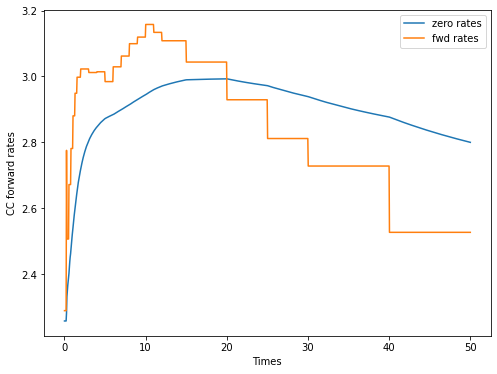

In [15]:
plt.figure(figsize=(8,6))
plt.plot(years, zero_rates*100, label="zero rates")
plt.plot(years, fwd_rates*100, label = "fwd rates")
plt.xlabel("Times")
plt.ylabel("CC forward rates")
plt.legend();

We see that the forward rates are piecewise flat

## Detailed Valuation

In [16]:
swaps[0].value(settlement_date, libor_curve, libor_curve)

-7.552444003522396e-09

In [18]:
swaps[0]._fixed_leg.value(settlement_date, libor_curve)

-53715.21909361753

In [19]:
swaps[0]._float_leg.value(settlement_date, libor_curve, libor_curve)

53715.21909360998

In [20]:
swaps[0].print_fixed_leg_pv()

START DATE: 08-JUN-2018
MATURITY DATE: 08-JUN-2020
COUPON (%): 2.776305
FREQUENCY: FrequencyTypes.SEMI_ANNUAL
DAY COUNT: DayCountTypes.THIRTY_E_360
PAY_DATE     ACCR_START   ACCR_END     DAYS  YEARFRAC    RATE      PAYMENT       DF          PV        CUM PV
10-DEC-2018  08-JUN-2018  10-DEC-2018   182  0.505556   2.77630     14035.76  0.98781403     13864.72     13864.72
10-JUN-2019  10-DEC-2018  10-JUN-2019   180  0.500000   2.77630     13881.52  0.97454325     13528.15     27392.87
09-DEC-2019  10-JUN-2019  09-DEC-2019   179  0.497222   2.77630     13804.41  0.96052302     13259.45     40652.32
08-JUN-2020  09-DEC-2019  08-JUN-2020   179  0.497222   2.77630     13804.41  0.94628478     13062.90     53715.22


In [21]:
swaps[0].print_float_leg_pv()

START DATE: 08-JUN-2018
MATURITY DATE: 08-JUN-2020
SPREAD (BPS): 0.0
FREQUENCY: FrequencyTypes.QUARTERLY
DAY COUNT: DayCountTypes.THIRTY_E_360
PAY_DATE     ACCR_START   ACCR_END     DAYS  YEARFRAC    IBOR      PAYMENT       DF          PV        CUM PV
10-SEP-2018  08-JUN-2018  10-SEP-2018    92  0.255556    2.33387      5964.33  0.99407103      5928.97      5928.97
10-DEC-2018  10-SEP-2018  10-DEC-2018    90  0.250000    2.53368      6334.19  0.98781403      6257.01     12185.97
08-MAR-2019  10-DEC-2018  08-MAR-2019    88  0.244444    2.62646      6420.24  0.98151248      6301.55     18487.52
10-JUN-2019  08-MAR-2019  10-JUN-2019    92  0.255556    2.79833      7151.28  0.97454325      6969.23     25456.75
09-SEP-2019  10-JUN-2019  09-SEP-2019    89  0.247222    2.90499      7181.78  0.96759420      6949.05     32405.80
09-DEC-2019  09-SEP-2019  09-DEC-2019    90  0.250000    2.94472      7361.81  0.96052302      7071.18     39476.98
09-MAR-2020  09-DEC-2019  09-MAR-2020    90  0.2500

Copyright (c) 2020 Dominic O'Kane